This notebook is used to prepare a critical difference plot and a Pareto frontier analysis plot.


In [2]:
cd ..

/storage/store3/soda/rcappuzz/retrieve-merge-predict/bench


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import polars as pl
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from src.utils.logging import read_and_process
from src.utils import plotting, constants
from src.utils.critical_difference_plot import critical_difference_diagram
import numpy as np
import seaborn as sns

sns.set_context("talk")
plt.style.use("seaborn-v0_8-talk")

In [5]:
df = pl.read_parquet("results/temp_results_retrieval.parquet")
df = df.with_columns(
    pl.when(pl.col("prediction_metric") < -1)
    .then(-1)
    .otherwise(pl.col("prediction_metric"))
    .alias("y")
)

In [6]:
keys = ["jd_method", "estimator", "aggregation", "chosen_model"]
exp_keys = ["base_table", "target_dl"]
names = df.unique(keys).select(keys).sort(keys).with_row_index("model")
df = df.join(names, on=keys, how="left")
experiments = (
    df.unique(exp_keys).select(exp_keys).sort(exp_keys).with_row_index("experiment")
)
df = df.join(experiments, on=exp_keys, how="left")

In [ ]:
keys = ["jd_method", "estimator", "aggregation", "chosen_model"]
exp_keys = ["base_table", "target_dl"]
names = df.unique(keys).select(keys).sort(keys).with_row_index("model")
df = df.join(names, on=keys, how="left")
experiments = (
    df.unique(exp_keys).select(exp_keys).sort(exp_keys).with_row_index("experiment")
)
df = df.join(experiments, on=exp_keys, how="left")

In [7]:
ranks = (
    df.group_by(["experiment", "model"])
    .agg(pl.mean("y"))
    .with_columns(
        pl.col("y").rank("ordinal", descending=True).over(["experiment"]).alias("rank")
    )
    .select("model", "rank")
)

In [8]:
rank_by_model = (
    df.group_by(["experiment", "model"])
    .agg(pl.mean("y"))
    .with_columns(
        pl.col("y").rank("ordinal", descending=True).over(["experiment"]).alias("rank")
    )
    .group_by("model")
    .agg(
        rank_median=pl.median("rank"),
        rank_mean=pl.mean("rank"),
    )
)

In [9]:
df_avg = df.group_by(keys).agg(pl.mean("y")).sort(keys).with_row_index(name="model")
p_values = sp.posthoc_conover(df.to_pandas(), val_col="y", group_col="model")

In [10]:
n = names.with_columns(
    prepared_name=pl.col("jd_method")
    + "-"
    + pl.col("estimator")
    + "-"
    + pl.col("aggregation")
    + "-"
    + pl.col("chosen_model")
).select(pl.col("model", "prepared_name"))
this_d = (
    ranks.group_by("model")
    .agg(pl.mean("rank"))
    .join(n, on="model")
    .select(["prepared_name", "rank"])
    # .with_columns(rank=-pl.col("rank"))
)
dd = dict(zip(*this_d.to_dict().values()))
colors = {
    "exact_matching": "green",
    "minhash_hybrid": "orange",
    "minhash": "red",
    "starmie": "blue",
}
color_props = {k: colors[k.split("-")[0]] for k in dd}

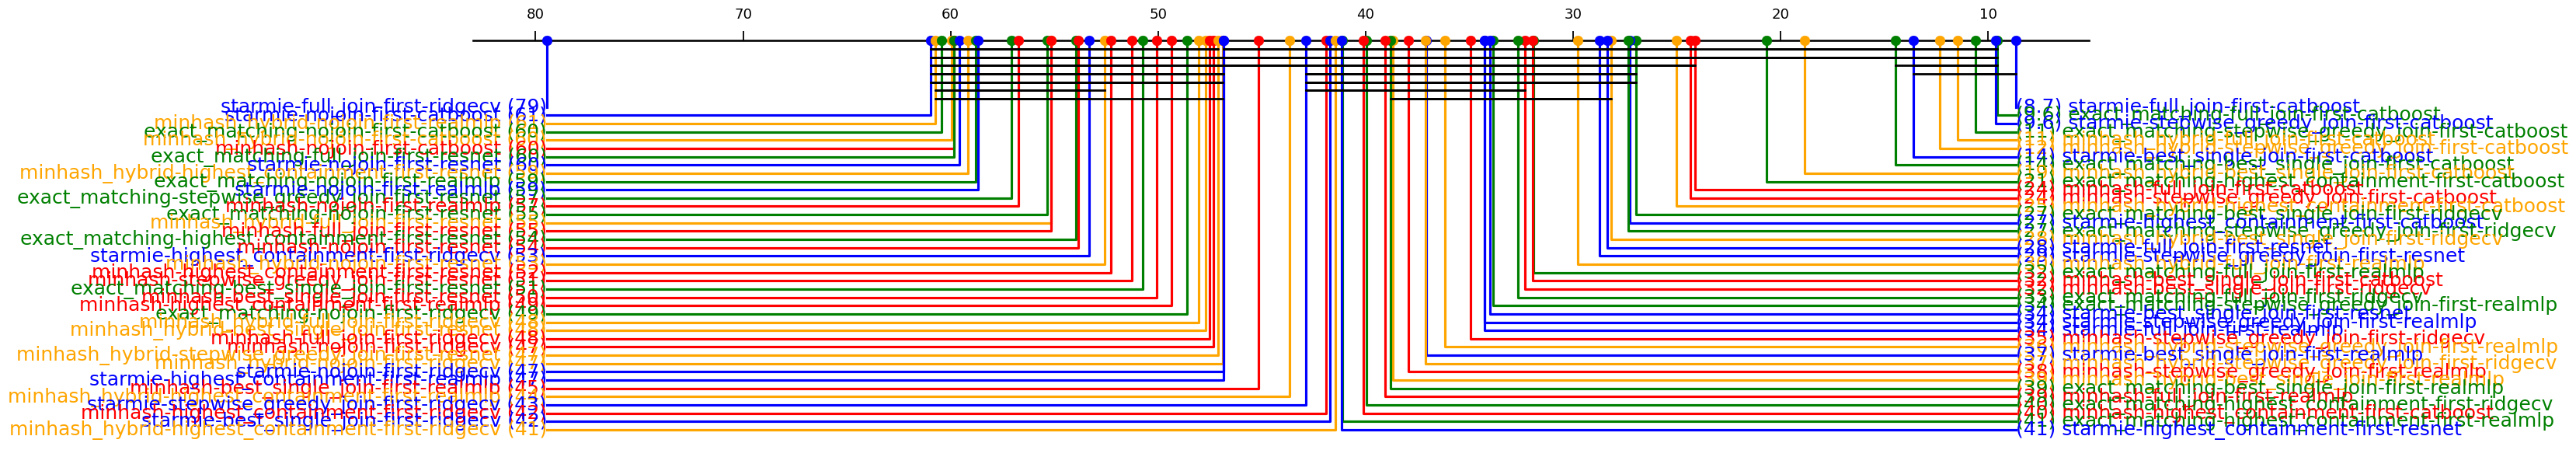

In [11]:
fig, ax = plt.subplots(
    1,
    1,
    squeeze=True,
)
_ = critical_difference_diagram(
    dd, p_values, color_palette=color_props, ascending=False
)
fig.subplots_adjust(left=0, right=2)
# fig.savefig(
#     "images/crit_diff_plot.png",
#     bbox_inches="tight",
#     # pad_inches=0.1
# )
# fig.savefig(
#     "images/crit_diff_plot.pdf",
#     bbox_inches="tight",
# )

## Pareto front


In [12]:
# Setting constants
hues = {0: "estimator", 1: "chosen_model", 2: "jd_method"}
titles = {0: "Selector", 1: "Prediction Model", 2: "Retrieval method"}
hue_order = {
    0: ["full_join", "highest_containment", "stepwise_greedy_join", "best_single_join"],
    1: ["catboost", "ridgecv", "resnet", "realmlp"],
    2: ["exact_matching", "starmie", "minhash", "minhash_hybrid"],
}
palettes = {0: "tab10", 1: "tab10", 2: "tab10"}

In [185]:
# Load retrieval stats
df_retrieval = pl.read_csv("stats/stats_retrieval_plot.csv")
df_retrieval = df_retrieval.rename({"index_name": "jd_method"}).filter(
    pl.col("data_lake_version") != "wordnet_vldb_50"
)

_d = df_retrieval.with_columns(
    cat=pl.col("jd_method").cast(pl.Categorical).cast(int)
).with_columns(
    cat=pl.when((pl.col("cat") == 1) | (pl.col("cat") == 2))
    .then(1)
    .otherwise(pl.col("cat"))
)
_d = _d.join(
    _d.group_by(["data_lake_version", "cat"]).agg(
        pl.mean("time_create", "time_save", "time_load")
    ),
    on=["data_lake_version", "cat"],
)

In [186]:
stats_retrieval = (
    _d.with_columns(
        time_retrieval=pl.when(pl.col("jd_method") != "starmie")
        .then(
            pl.sum_horizontal(
                [
                    "time_create_right",
                    "time_save_right",
                    "time_load_right",
                    "time_query",
                ]
            )
        )
        .otherwise("total_retrieval")
    )
    .group_by(["data_lake_version", "jd_method"])
    .agg(pl.mean("peak_memory"), pl.mean("time_retrieval"))
)

df_ = (
    df.join(
        stats_retrieval,
        left_on=["target_dl", "jd_method"],
        right_on=["data_lake_version", "jd_method"],
    )
    .with_columns(max_ram=pl.max_horizontal("peak_fit", "peak_predict", "peak_memory"))
    .with_columns(total_time=pl.col("time_run") + pl.col("time_retrieval"))
    .filter(pl.col("estimator") != "nojoin")
)

res = df_.group_by(keys).agg(
    pl.mean("total_time"),
    pl.mean("y"),
    pl.mean("time_run"),
    pl.mean("max_ram"),
    pl.mean("peak_fit"),
)

### Time

(3.500208836098355, 9288.936508572562)
(3.438051908401352, 13532.501033629567)
(3.373974731575028, 20089.112330742966)


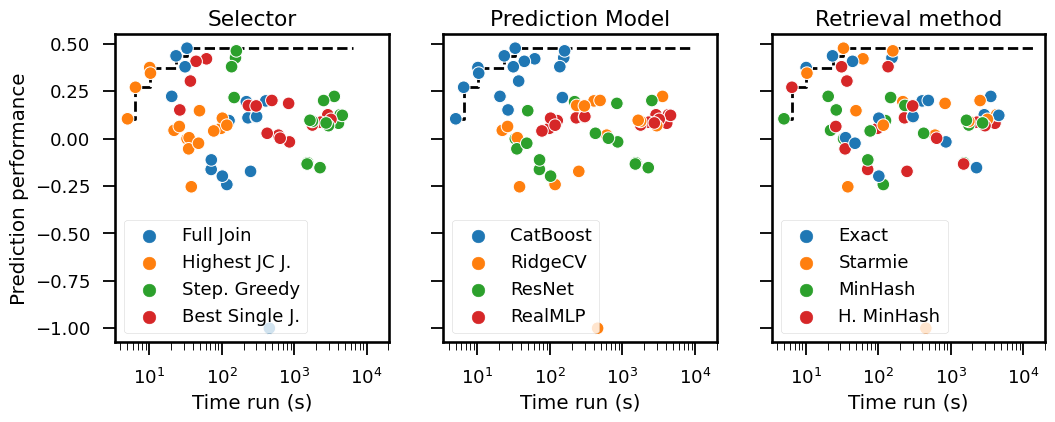

In [187]:
fig, axs = plt.subplots(1, 3, squeeze=True, sharey=True, sharex=True, figsize=(12, 4))

axs[0].set_xscale("log")
axs[0].set_ylabel("Prediction performance")

variable = "time_run"
for idx, ax in enumerate(axs):

    x = res[variable]
    y = res["y"]

    xs = np.array(x)
    ys = np.array(y)
    perm = np.argsort(xs)
    xs = xs[perm]
    ys = ys[perm]
    sns.scatterplot(
        data=res.to_pandas(),
        x=variable,
        y="y",
        hue=hues[idx],
        ax=ax,
        palette=palettes[idx],
        hue_order=hue_order[idx],
    )

    xs_pareto = [xs[0], xs[0]]
    ys_pareto = [ys[0], ys[0]]
    for i in range(1, len(xs)):
        if ys[i] > ys_pareto[-1]:
            xs_pareto.append(xs[i])
            ys_pareto.append(ys_pareto[-1])
            xs_pareto.append(xs[i])
            ys_pareto.append(ys[i])
    xs_pareto.append(ax.get_xlim()[1])
    ys_pareto.append(ys_pareto[-1])

    ax.plot(xs_pareto, ys_pareto, "--", color="k", linewidth=2, zorder=0.8)

    print(ax.get_xlim())
    ax.set_title(titles[idx])
    h, l = ax.get_legend_handles_labels()
    ax.legend(
        h,
        [constants.LABEL_MAPPING[hues[idx]][_] for _ in l],
        title=None,
    )
    ax.set_xlabel("Time run (s)")

# fig.savefig("images/pareto_frontier_time.pdf")
# fig.savefig("images/pareto_frontier_time.png")

### Peak fit

In [188]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def gigabyte_formatter(x, pos):
    return f"{x/1e3:.0f} GB"


# Create a FuncFormatter object
gb_formatter = FuncFormatter(gigabyte_formatter)

(2871.81625270907, 10368.759047335156)
(2863.4489454871864, 11023.971559340234)
(2854.689509461153, 11756.551510844782)


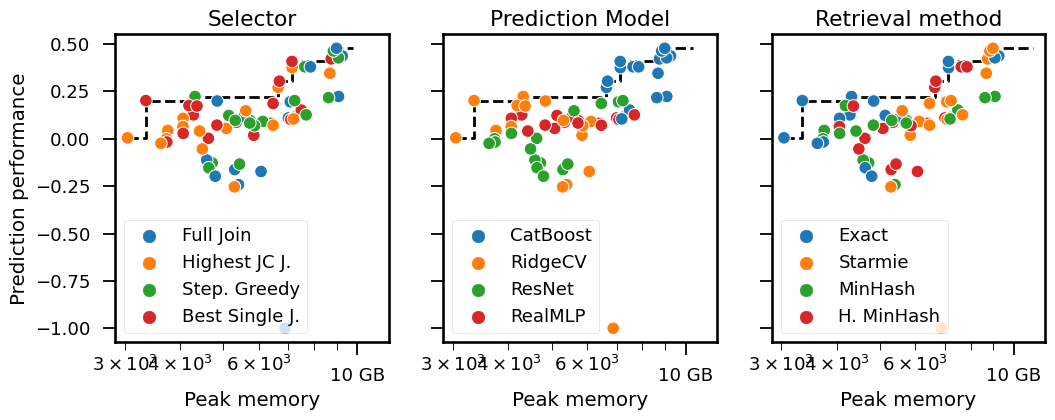

In [189]:
fig, axs = plt.subplots(1, 3, squeeze=True, sharey=True, sharex=True, figsize=(12, 4))

for idx, ax in enumerate(axs):
    x = res["peak_fit"]
    y = res["y"]
    axs[0].set_xscale("log")
    axs[0].set_ylabel("Prediction performance")
    axs[0].xaxis.set_major_formatter(gb_formatter)

    xs = np.array(x)
    ys = np.array(y)
    perm = np.argsort(xs)
    xs = xs[perm]
    ys = ys[perm]

    sns.scatterplot(
        data=res.to_pandas(),
        x="peak_fit",
        y="y",
        hue=hues[idx],
        ax=ax,
        palette=palettes[idx],
        hue_order=hue_order[idx],
    )

    xs_pareto = [xs[0], xs[0]]
    ys_pareto = [ys[0], ys[0]]
    for i in range(1, len(xs)):
        if ys[i] > ys_pareto[-1]:
            xs_pareto.append(xs[i])
            ys_pareto.append(ys_pareto[-1])
            xs_pareto.append(xs[i])
            ys_pareto.append(ys[i])
    xs_pareto.append(ax.get_xlim()[1])
    ys_pareto.append(ys_pareto[-1])

    ax.plot(xs_pareto, ys_pareto, "--", color="k", linewidth=2, zorder=0.8)

    print(ax.get_xlim())
    ax.set_title(titles[idx])
    h, l = ax.get_legend_handles_labels()
    ax.legend(
        h,
        [constants.LABEL_MAPPING[hues[idx]][_] for _ in l],
        title=None,
    )
    ax.set_xlabel("Peak memory")

# fig.savefig("images/pareto_frontier_ram.pdf")
# fig.savefig("images/pareto_frontier_ram.png")

### Combined

In [190]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def major_gigabyte_formatter(x, pos):
    return f"{x/1e3:.0f} GB"


def minor_gigabyte_formatter(x, pos):
    return f"{x/1e3:.0f}"


def major_time_formatter(x, pos):
    return f"{x/60:.0f}min"


# Create a FuncFormatter object
major_gb_formatter = FuncFormatter(major_gigabyte_formatter)
minor_gb_formatter = FuncFormatter(minor_gigabyte_formatter)

Text(0.02, 0.5, 'Prediction Performance')

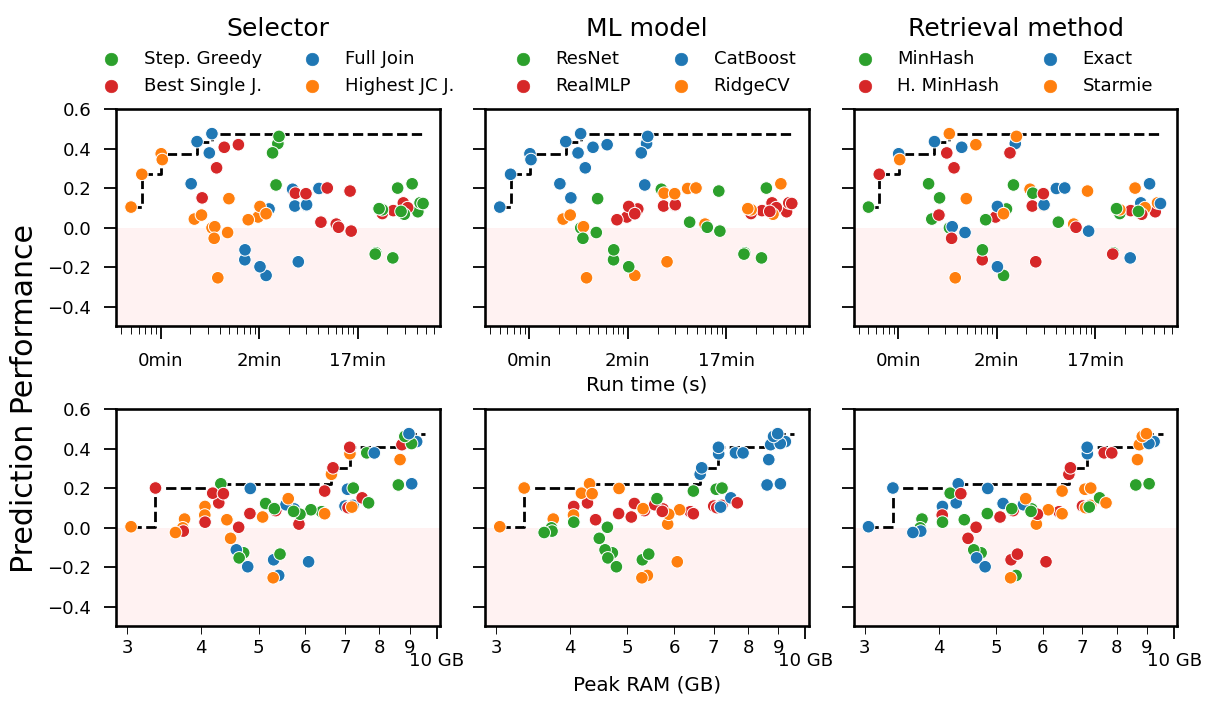

In [204]:
fig, axs = plt.subplots(
    2,
    3,
    sharey=True,
    layout="constrained",
    figsize=(12, 6),
    gridspec_kw={"wspace": 0.01},
)


# Time
data = res.to_pandas()
y_var = "y"

map_xlabel = {
    "time_run": "Run time (s)",
    "peak_fit": "Peak RAM (GB)",
    "max_ram": "Peak RAM (GB)",
    "total_time": "Retrieval + Training time (s)",
}

plot_vars = ["time_run", "peak_fit"]

for idx_1 in range(2):
    x_var = plot_vars[idx_1]
    for idx_2 in range(3):
        var_ = hues[idx_2]
        ax = axs[idx_1][idx_2]
        ax.set_ylim([-0.5, 0.6])
        ax.axhspan(0, -0.5, zorder=0, alpha=0.05, color="red")

        if idx_2 == 1:
            _xlabel = map_xlabel[x_var]
        else:
            _xlabel = ""
        h, l = plotting.pareto_frontier_plot(
            data,
            x_var,
            y_var,
            hue_var=hues[idx_2],
            palette="tab10",
            hue_order=hue_order[idx_2],
            ax=ax,
            ax_title="",
            ax_xlabel=_xlabel,
        )
        l = [constants.LABEL_MAPPING[hues[idx_2]][_] for _ in l]

        # first row
        if idx_1 == 0:
            ax.set_xscale("log")

            ax.legend(
                h,
                l,
                loc="upper center",
                bbox_to_anchor=(0.5, 1.5),
                title=constants.LABEL_MAPPING["variables"][var_],
                ncols=2,
                mode="expand",
                edgecolor="white",
            )
            ax.xaxis.set_major_formatter(major_time_formatter)
        else:
            ax.get_legend().remove()
            # ax.legend([], [], edgecolor="white")
            ax.set_xscale("log")

            ax.xaxis.set_major_formatter(major_gb_formatter)
            ax.xaxis.set_minor_formatter(minor_gb_formatter)


fig.supylabel("Prediction Performance")

### Aggregation

In [218]:
df = pl.read_parquet("results/temp_results_aggregation.parquet")
df = df.with_columns(
    pl.when(pl.col("prediction_metric") < -1)
    .then(-1)
    .otherwise(pl.col("prediction_metric"))
    .alias("y")
)

In [220]:
keys = ["jd_method", "estimator", "aggregation", "chosen_model"]
exp_keys = ["base_table", "target_dl"]
names = df.unique(keys).select(keys).sort(keys).with_row_index("model")
df = df.join(names, on=keys, how="left")
experiments = (
    df.unique(exp_keys).select(exp_keys).sort(exp_keys).with_row_index("experiment")
)
df = df.join(experiments, on=exp_keys, how="left")

In [221]:
df_ = (
    df.join(
        stats_retrieval,
        left_on=["target_dl", "jd_method"],
        right_on=["data_lake_version", "jd_method"],
    )
    .with_columns(max_ram=pl.max_horizontal("peak_fit", "peak_predict", "peak_memory"))
    .with_columns(total_time=pl.col("time_run") + pl.col("time_retrieval"))
    .filter(pl.col("estimator") != "nojoin")
)

res = df_.group_by(keys).agg(
    pl.mean("total_time"),
    pl.mean("y"),
    pl.mean("time_run"),
    pl.mean("max_ram"),
    pl.mean("peak_fit"),
)

In [222]:
res

jd_method,estimator,aggregation,chosen_model,total_time,y,time_run,max_ram,peak_fit
str,str,str,str,f64,f64,f64,f64,f64
"""minhash""","""best_single_jo…","""first""","""realmlp""",2965.131302,0.087372,935.739727,6188.636024,4140.683225
"""minhash_hybrid…","""highest_contai…","""mean""","""resnet""",2665.933322,0.142797,15.08325,7725.436937,3297.788238
"""exact_matching…","""highest_contai…","""first""","""realmlp""",1406.388466,0.149179,47.694891,2909.700304,2909.700304
"""exact_matching…","""highest_contai…","""first""","""catboost""",1367.004399,0.455986,8.310825,6136.001324,6135.995291
"""minhash_hybrid…","""highest_contai…","""dfs""","""ridgecv""",2694.135803,-0.195813,43.285732,7606.885201,3066.901432
"""minhash_hybrid…","""best_single_jo…","""mean""","""resnet""",2858.546214,0.154359,207.696142,7763.690453,3442.059679
"""minhash_hybrid…","""highest_contai…","""dfs""","""realmlp""",2499.960853,0.298422,58.526854,7440.170999,3861.924426
"""exact_matching…","""highest_contai…","""dfs""","""resnet""",1400.748176,0.357002,42.054601,2597.899219,2597.786979
"""exact_matching…","""highest_contai…","""first""","""ridgecv""",1377.496751,-0.112422,18.803176,2004.170139,2004.09197


(2.7396841278600332, 2873.4111832067574)
(2.696716376896597, 4004.6763294135735)


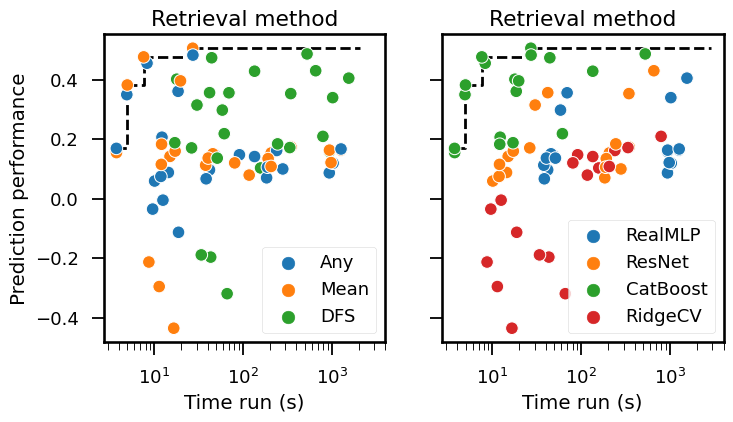

In [228]:
fig, axs = plt.subplots(1, 2, squeeze=True, sharey=True, sharex=True, figsize=(8, 4))

axs[0].set_xscale("log")
axs[0].set_ylabel("Prediction performance")

variable = "time_run"
x = res[variable]
y = res["y"]


groups = ["aggregation", "chosen_model"]
for idx_, ax in enumerate(axs):
    xs = np.array(x)
    ys = np.array(y)
    perm = np.argsort(xs)
    xs = xs[perm]
    ys = ys[perm]
    sns.scatterplot(
        data=res.to_pandas(),
        x=variable,
        y="y",
        hue=groups[idx_],
        ax=ax,
        palette=palettes[idx],
        # hue_order=hue_order[idx],
    )

    xs_pareto = [xs[0], xs[0]]
    ys_pareto = [ys[0], ys[0]]
    for i in range(1, len(xs)):
        if ys[i] > ys_pareto[-1]:
            xs_pareto.append(xs[i])
            ys_pareto.append(ys_pareto[-1])
            xs_pareto.append(xs[i])
            ys_pareto.append(ys[i])
    xs_pareto.append(ax.get_xlim()[1])
    ys_pareto.append(ys_pareto[-1])

    ax.plot(xs_pareto, ys_pareto, "--", color="k", linewidth=2, zorder=0.8)

    print(ax.get_xlim())
    ax.set_title(titles[idx])
    h, l = ax.get_legend_handles_labels()
    ax.legend(
        h,
        [constants.LABEL_MAPPING[groups[idx_]][_] for _ in l],
        title=None,
    )
    ax.set_xlabel("Time run (s)")